# Flow modelling – Altering flows

In [1]:
import graph_tool as gt
import graph_tool.draw
import numpy as np
import datetime
import cairo

In [2]:
print("Date:", datetime.datetime.now().date().isoformat())

Date: 2018-10-03


## Test data

Let's create an test graph that models cucumber production, packaging and consumption.

In [3]:
G = gt.Graph(directed=True)
G.load("cucumba.gt")

## Flow splitting

In the GDSE, flows have two properties, *mass* [tons] and *material composition* [fraction]. In order to compute stuff in the graph, the flows (edges) need to be split per material, often resulting in paralell edges.

In [4]:
def split_flows(G):
    """Split the flows based on material composition
    
    If a flow is composed of different materials, it is split into individual flows per material 
    with the corresponding mass.
    If the flow is composed of a single material, the composition property is removed and replaced with material.
    
    Returns
    -------
    graph
        The updated graph
    eprop_material
        Edge property (materials), string
    eprop_mass
        Edge property (mass), double
    vtx_mask
        Vertex property, bool
    """
    g = G.copy()
    g.clear_edges()
    del g.edge_properties['flow']
    eprops = G.edge_properties.keys()
    mass_list = []
    material_list = []
    assert 'flow' in eprops, "The graph must have 'flow' edge property"
    e_list = []
    for e in G.edges():
        prop = G.ep.flow[e]
        assert isinstance(prop, dict), "Edge property flow must be a dictionary in edge {}".format(e)
        for material, percent in prop['composition'].items():
            e_list.append(np.array([e.source(), e.target()], dtype=int))
            mass_list.append(float(prop['mass']) * float(percent))
            material_list.append(material)
    e_array = np.vstack(e_list)
    g.add_edge_list(e_array)
    eprop_mass = g.new_edge_property("float", vals=mass_list)
    eprop_mass_text = g.new_edge_property("string", vals=[round(i,2) for i in mass_list])
    eprop_material = g.new_edge_property("string", vals=material_list)
    r = (False for x in g.get_vertices())
    vtx_mask = g.new_vertex_property("bool", vals=r)
    return (g, eprop_material, eprop_mass, eprop_mass_text, vtx_mask)

In [5]:
g_split, eprop_material, eprop_mass, eprop_mass_text, vtx_mask = split_flows(G)

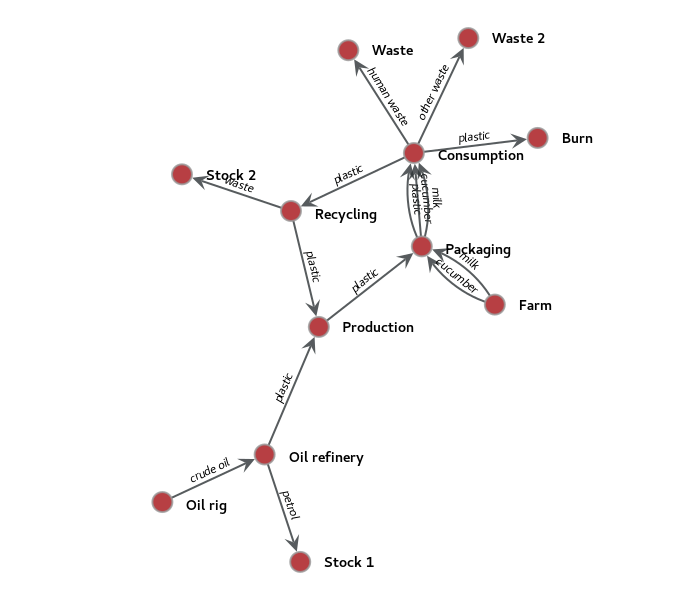

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f47790955c0, at 0x7f477902b2b0>

In [6]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC},
                   edge_text=eprop_material,
                   output_size=(700,600), inline=True)

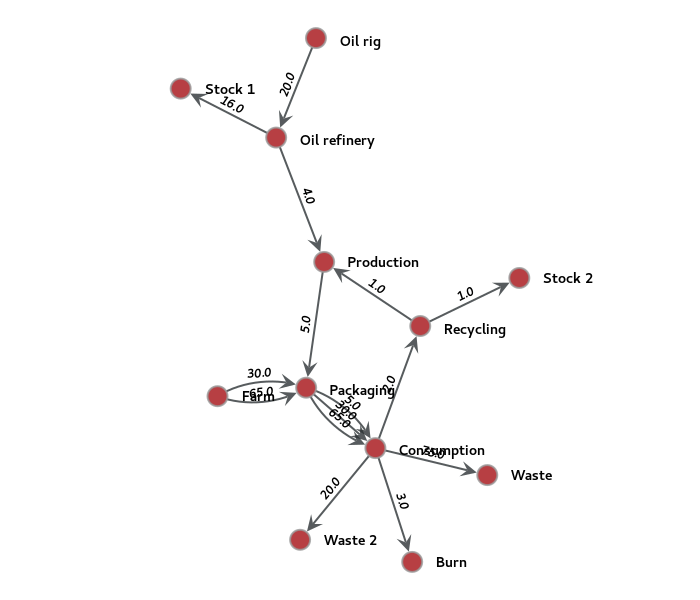

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f47790955c0, at 0x7f477902beb8>

In [7]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "text":eprop_mass_text, "font_weight": cairo.FONT_WEIGHT_BOLD},
                   output_size=(700,600), inline=True)

## Functions

In [14]:
def define_mask(g, eprop_material, materials):
    """Create an edge mask for the edges that contribute to the solution
    
    g - graph
    eprop_material - edge property map of the materials
    materials - list of strings, if an edge has a material in this list, the edge is included
    """
    cols = []
    mask = g.new_edge_property("bool")
    for i,e in enumerate(g.edges()):
        if eprop_material[e] in materials:
            mask[e] = True
            cols.append("green")
        else:
            mask[e] = False
            cols.append("red")
    
    return (mask, g.new_edge_property("string", vals=cols))

In [20]:
def compute_balancing_factor(sol_e, solution, eprop_mass):
    """Compute the balancing factor for a solution from a solution-edge
    
    sol_e - the solution edge (graph edge)
    solution - solution (float)
    eprop_mass - edge property map of masses
    """
    bf = solution / eprop_mass[sol_e]
    if bf < 1.0:
        balancing_factor = 1.0 - bf
    else:
        balancing_factor = bf
    return balancing_factor

In [25]:
def mass_balancer(g, eprop_mass, mask, sol_e, solution):
    g.clear_filters()
    balancing_factor = compute_balancing_factor(sol_e, solution, eprop_mass)
    eprop_mass_sol = eprop_mass.copy()
    eprop_mass_sol[sol_e] = eprop_mass[sol_e] * balancing_factor

    for i,e in enumerate(g.edges()):
        if mask[e]:
            src = e.source()
            if src.in_degree() > 0:
                all_in = src.in_edges()
                all_out = src.out_edges()
                s = []
                f = []
                for ein in all_in:
                    s.append(eprop_mass[ein])
                    if mask[ein]:
                        f.append(eprop_mass[ein])
                sum_in = sum(s)
                flow = sum(f)
                sum_siblings_sol = sum([eprop_mass[out] for out in all_out if mask[out]]) # sum of mass of the siblings that belong the the solution
                portion_in = flow * (eprop_mass[e] / sum_siblings_sol) # portion of incoming mass in the current edge (solution edges only)
                portion_rest = eprop_mass[e] - portion_in # the rest of the flow which does not stem from the incoming solution edge
                new_mass = ( portion_in * balancing_factor ) + portion_rest
            else:
                new_mass = eprop_mass[e] * balancing_factor
            if new_mass <= eprop_mass[e]:
                eprop_mass_sol[e] = -1 * (eprop_mass[e] - new_mass)
            else:
                eprop_mass_sol[e] = new_mass - eprop_mass[e]       
        else:
            eprop_mass_sol[e] = 0
    
    return eprop_mass_sol

In [44]:
def plot_sol_mass(g, colors, mass):
    mass_text = g.new_edge_property("string", vals=[round(i,2) for i in mass])
    gt.draw.graph_draw(g, vertex_size=20, vertex_text=g.vp.id,
                       vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                       eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":colors},
                       edge_text=mass_text,
                       output_size=(700,600), inline=True)

In [29]:
def plot_sol_materials(g, colors, eprop_material):
    gt.draw.graph_draw(g, vertex_size=20, vertex_text=g.vp.id,
                       vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                       eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":colors},
                       edge_text=eprop_material,
                       output_size=(700,600), inline=True)

## Solution 1 – plastic reduction

*Reduce the amount of plastic between Packaging and Consumption by 20% in the part of the cucumber packaging* (blue edge)

In other words:

There are 30t of cucumbers (net), plus 5% over it in plastic, thus 1,5t of plastic, between Packaging and Consumption. The solution reduces the 1,5t by 20%, thus there will be only **1,2t** of plastic (blue arrow). As an effect, the plastic-related upstream and downstream flows need to change, but the *1,2t* will stay as set manually.

In [8]:
pe = g_split.edge(g_split.vertex(1), g_split.vertex(6), all_edges=True) # the 3 edges between Packaging and Cosumption
sol_e = [e for e in pe if eprop_material[e] == 'plastic'][0] # the specific edge (blue)

In [9]:
# Now we 'implement' the solution.
# The plastic flow contains the combined mass from cucumber and milk packaging, which is 5.0t. From the 5.0t, 1,5t was
# used for cucumbers as explained above. Now, the solution reduces the packaging of cucumbers by 0.3t
print("Current combined plastic mass after Packaging:", eprop_mass[sol_e])
solution = 0.3
print("Plastic mass after implementing the solution:", eprop_mass[sol_e] - solution)

Current combined plastic mass after Packaging: 5.0
Plastic mass after implementing the solution: 4.7


### Restricting the graph with the Solution

We need to restrict the graph to the flows that are involved in the *Solution*, otherwise flows might be altered that are not affected by the solution. For example, the solution affects the *Packaging* activity and reduces the amount of plastic packaging on cucumbers by 20%. Thus neither the amount of cucumbers nor the amount of milk should be changed.

Both the milk and cucumber *packaged product* consists of 5% plastic.

Thus the provided solution modfies the *green* edges and must not modify the *red* edges. The user is supposed to manually select the flows (green and blue edges) that are affected by the solution.

In [15]:
edge_mask_1, ecolors_1 = define_mask(g_split, eprop_material, ['plastic', 'crude oil'])

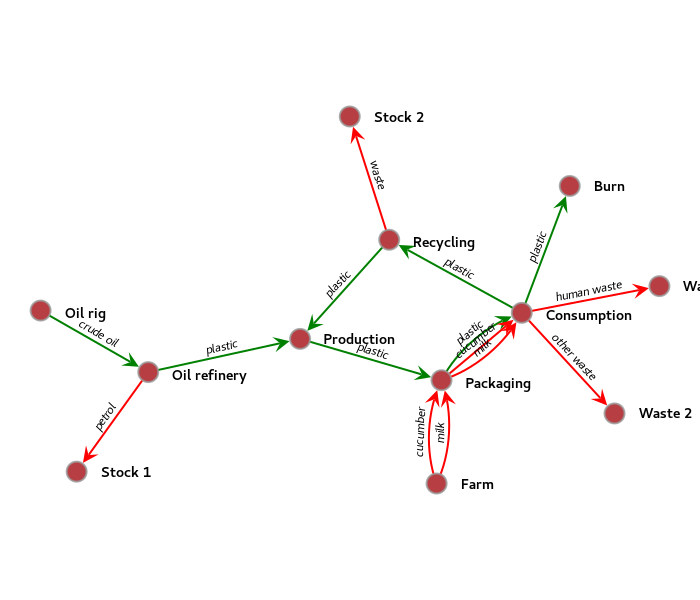

In [30]:
plot_sol_materials(g_split, ecolors_1, eprop_material)

#### Alternative 2

Compute $balancing\_factor=\frac{solution}{solution\_flow}$ , where *solution* is the amount in *t* by which the *Solution* modifies the *solution_flow* (the *plastic* between *Packaging* and *Consumption*)

Multiply each edge in the restricted graph by the *balancing_factor*

In [26]:
mass_sol1 = mass_balancer(g_split, eprop_mass, edge_mask_1, sol_e, solution)

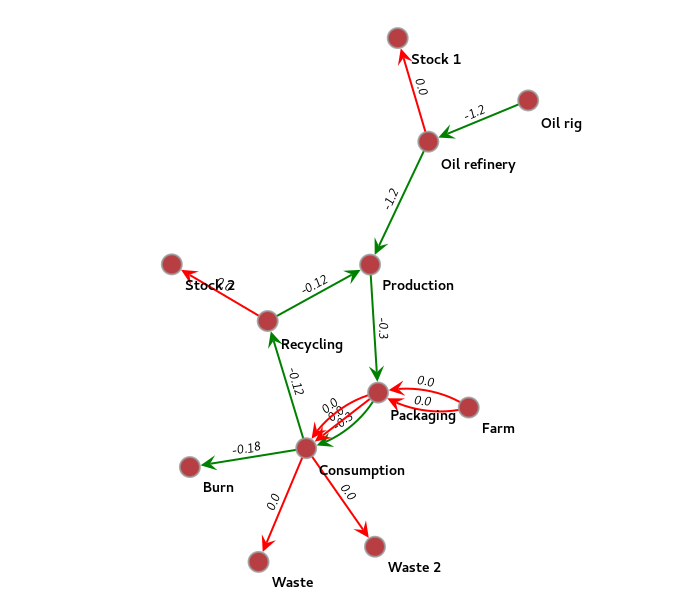

In [45]:
plot_sol_mass(g_split, ecolors_1, mass_sol1)

## Solution 2 – milk reduction

*Reduce milk production by 40%*

The current milk production is $0.6842*95=65t$ , after implementing the solution it will be reduced by 26t. Thus the __*balancing_factor* for milk is 0.6__.

Milk is also packaged in plastic, which is *5.4%* ( 3.5/65=0.054 ) over the net mass of the milk. Reducing the milk also reduces the plastic, thus at the end we'll end up with $(65t * 0.6) * 0.054 = 2.106t$ of plastic packaging for the milk. Thus the __*balancing_factor* for plastic is__ 2.106/3.5=__0.6017__ 

In [40]:
pe = g_split.edge(g_split.vertex(0), g_split.vertex(1), all_edges=True) # the 2 edges between Farm and Packaging
sol_e_2 = [e for e in pe if eprop_material[e] == 'milk'][0] # the specific edge (blue)
solution_2 = 26

print("Current milk mass after Farm", round(eprop_mass[sol_e],2))
print("Milk mass after implementing the solution", round(eprop_mass[sol_e] - solution,2))

Current milk mass after Farm 65.0
Milk mass after implementing the solution 39.0


The flows affected by the solution are manually selected by the user.

In [35]:
edge_mask_2, ecolors_2 = define_mask(g_split, eprop_material, ['milk', 'human waste', 'other waste'])

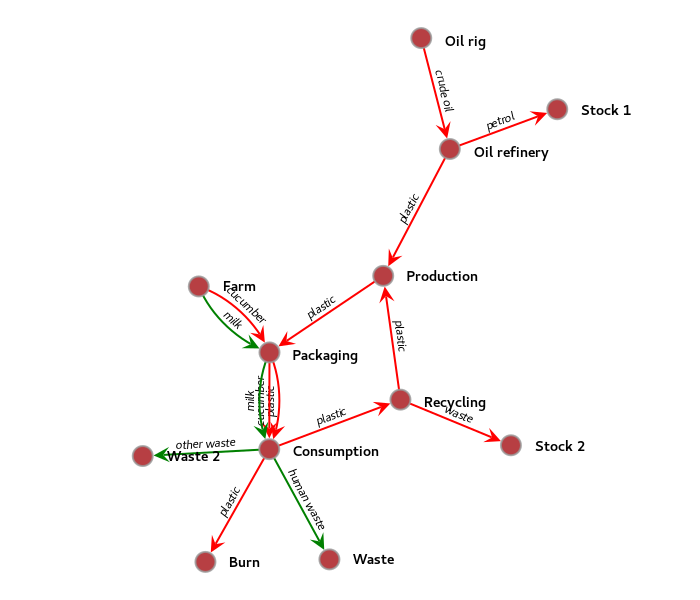

In [39]:
plot_sol_materials(g_split, ecolors_2, eprop_material)

The flow between *Consumption* and *Waste* has a different material (human waste, other waste) than milk. Because this flow (human waste, other waste) doesn't have a composition, we need to calcuate the ratio of milk in it.

### Mass calculation method

We have:

$current\_flow$ is the mass of the current edge 

$sum\_siblings$ is the sum of all flows that have the same origin as $current\_flow$ and that are part of the solution

$sum\_inflows$ is the sum of all inflows to the origin of $current\_flow$ and that are part of the solution

Then we can compute:

$$portion\_in = sum\_inflows * (\frac{current\_flow}{sum\_siblings})$$

$$portion\_rest = current\_flow - portion\_in$$

Where $portion\_in$ is the portion of incoming mass in the current flow (solution flows only), $portion\_rest$ is the rest of the flow which does not stem from the incoming flow that is used for calcuating $portion\_in$.

And finally obtain the adjusted flow as:

$$ new\_mass = ( portion\_in * balancing\_factor ) + portion\_rest $$



In [42]:
mass_sol2 = mass_balancer(g_split, eprop_mass, edge_mask_2, sol_e_2, solution_2)

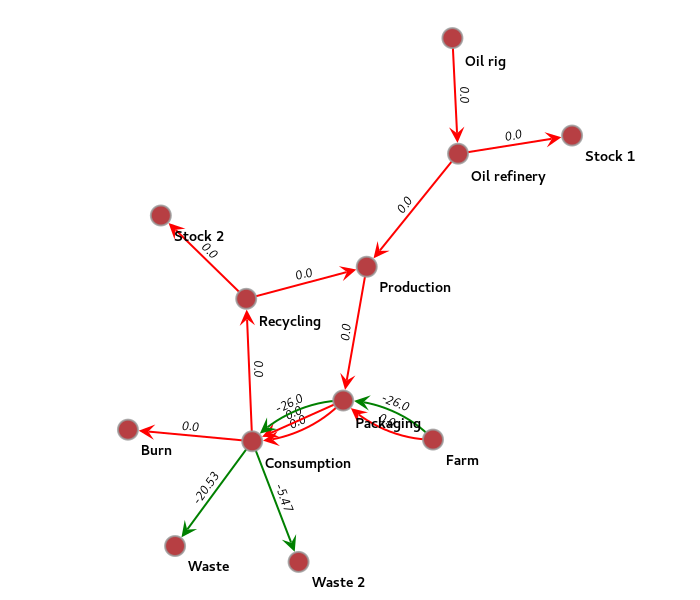

In [46]:
plot_sol_mass(g_split, ecolors_2, mass_sol2)

### Compute for the plastic part

Let's compute our expectation for the plastic reduction.

In [49]:
g_split.clear_filters() # remove the edge and vertex masks
pe = g_split.edge(g_split.vertex(1), g_split.vertex(6), all_edges=True) # the 3 edges between Packaging and Cosumption
sol_e_3 = [e for e in pe if eprop_material[e] == 'plastic'][0] # the specific edge (blue)
solution_3 = 0.6017 #Solution-2-–-milk-reduction

print("Current combined plastic mass after Packaging:", eprop_mass[sol_e])
print("Solution reduces the plastic mass by:", solution, "on the solution edge")
print("Plastic mass of the solution edge after implementing the solution:", round(eprop_mass[sol_e] - solution,2))

Current combined plastic mass after Packaging: 64.99900000000001
Solution reduces the plastic mass by: 26 on the solution edge
Plastic mass of the solution edge after implementing the solution: 39.0


In [50]:
edge_mask_3, ecolors_3 = define_mask(g_split, eprop_material, ['plastic', 'crude oil'])
mass_sol3 = mass_balancer(g_split, eprop_mass, edge_mask_3, sol_e_3, solution_3)

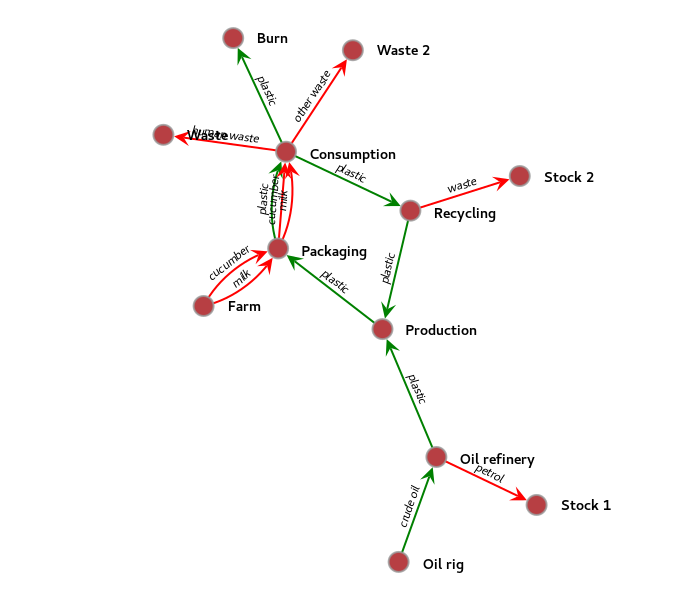

In [52]:
plot_sol_materials(g_split, ecolors_3, eprop_material)

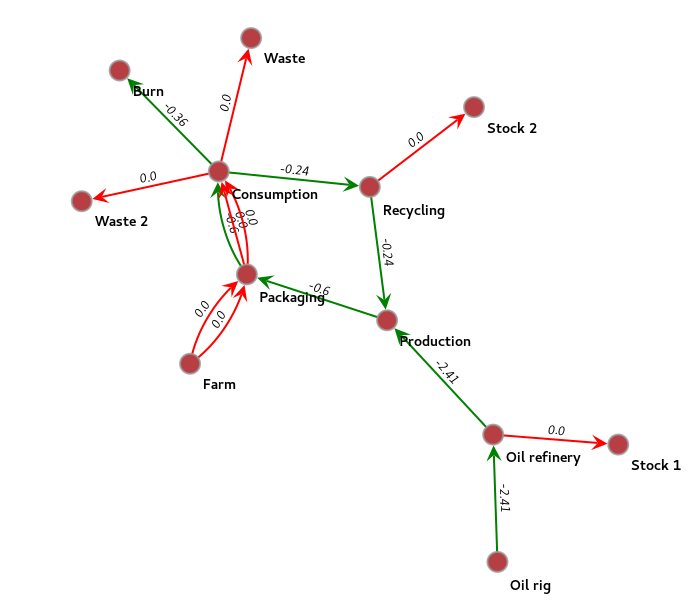

In [53]:
plot_sol_mass(g_split, ecolors_3, mass_sol3)

## Combining solutions or solution-parts

A **solution** is defined by
1. amount of change
2. affected material
3. the edge on which the solution is applied

**Solution-graph**: A subset of the graph/system containing only the edges that are affected by the solution and on which a solution has been already applied, thus the flows have been altered.

**Solution-part**: A solution can have several parts in case the desired change in a material results in changes in other materials. For example reducing the milk production also reduces the plastic production.

Once we computed the solution-parts for the milk and for the plastic, we need to integrate both into a single graph which then represents *the* complete solution. In a similar fashion, it should be possible to combine solutions that are part of a strategy.

The straightforward approach is to sum up the mass changes of each solution graph. In which case:

    for each edge:

        final mass = original mass + solution 1 + ... + solution n
        
But this requires that solution_n is the signed amount of change in mass for a particular edge, not the amount after applying the solution.

In [56]:
for i,e in enumerate(g_split.edges()):
    formula = "{eid}    {omass} + {s1}[mask {m1}] + {s2}[mask {m2}] + {s3}[mask {m3}] = {res}".format(
        eid=i, omass=eprop_mass[e],
        s1=round(mass_sol1[e],2), s2=round(mass_sol2[e],2), 
        s3=round(mass_sol3[e],2), m1=edge_mask_1[e], m2=edge_mask_2[e], m3=edge_mask_3[e],
        res=round(sum([eprop_mass[e], mass_sol1[e], mass_sol2[e], mass_sol3[e]]), 2)
    )
    print(formula)

0    30.001 + 0.0[mask 0] + 0.0[mask 0] + 0.0[mask 0] = 30.0
1    64.99900000000001 + 0.0[mask 0] + -26.0[mask 1] + 0.0[mask 0] = 39.0
2    5.0 + -0.3[mask 1] + 0.0[mask 0] + -0.6[mask 1] = 4.1
3    30.0 + 0.0[mask 0] + 0.0[mask 0] + 0.0[mask 0] = 30.0
4    65.0 + 0.0[mask 0] + -26.0[mask 1] + 0.0[mask 0] = 39.0
5    20.0 + -1.2[mask 1] + 0.0[mask 0] + -2.41[mask 1] = 16.39
6    16.0 + 0.0[mask 0] + 0.0[mask 0] + 0.0[mask 0] = 16.0
7    4.0 + -1.2[mask 1] + 0.0[mask 0] + -2.41[mask 1] = 0.39
8    5.0 + -0.3[mask 1] + 0.0[mask 0] + -0.6[mask 1] = 4.1
9    75.0 + 0.0[mask 0] + -20.53[mask 1] + 0.0[mask 0] = 54.47
10    3.0 + -0.18[mask 1] + 0.0[mask 0] + -0.36[mask 1] = 2.46
11    2.0 + -0.12[mask 1] + 0.0[mask 0] + -0.24[mask 1] = 1.64
12    20.0 + 0.0[mask 0] + -5.47[mask 1] + 0.0[mask 0] = 14.53
13    1.0 + 0.0[mask 0] + 0.0[mask 0] + 0.0[mask 0] = 1.0
14    1.0 + -0.12[mask 1] + 0.0[mask 0] + -0.24[mask 1] = 0.64


In [54]:
for i,e in enumerate(g_split.edges()):
    formula = "{eid}    {src} --> {dst}    change:  {ch}t  {mat}".format(
        eid=i, src=g_split.vp.id[e.source()], dst=g_split.vp.id[e.target()], mat=eprop_material[e], 
        ch=round(sum([mass_sol1[e],mass_sol2[e],mass_sol3[e]]), 2)
    )
    print("")
    print(formula)


0    Farm --> Packaging    change:  0.0t  cucumber

1    Farm --> Packaging    change:  -26.0t  milk

2    Packaging --> Consumption    change:  -0.9t  plastic

3    Packaging --> Consumption    change:  0.0t  cucumber

4    Packaging --> Consumption    change:  -26.0t  milk

5    Oil rig --> Oil refinery    change:  -3.61t  crude oil

6    Oil refinery --> Stock 1    change:  0.0t  petrol

7    Oil refinery --> Production    change:  -3.61t  plastic

8    Production --> Packaging    change:  -0.9t  plastic

9    Consumption --> Waste    change:  -20.53t  human waste

10    Consumption --> Burn    change:  -0.54t  plastic

11    Consumption --> Recycling    change:  -0.36t  plastic

12    Consumption --> Waste 2    change:  -5.47t  other waste

13    Recycling --> Stock 2    change:  0.0t  waste

14    Recycling --> Production    change:  -0.36t  plastic
